In [1]:
%matplotlib inline
#import autoreload
%load_ext autoreload
%autoreload

In [ ]:
#|default_exp assignment12_pl_code

In [2]:
!mamba install -U git+https://github.com/albu/albumentations --no-cache-dir

/bin/bash: line 1: mamba: command not found


In [2]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-s3nzcf5m
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-s3nzcf5m
  Resolved https://github.com/albu/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=ecb95a1514066903f2c31d6140dad5d469bbb49ab6a8ffa67d4a157944b1fb47
  Stored in directory: /tmp/pip-ephem-wheel-cache-ev4v85ep/wheels/3c/df/16/b3d0d64428c9f25b1ab03989a2e574546d3336647946d31e56
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [7]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 12.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/Assignment12/ERA_S12-main

/content/drive/MyDrive/Assignment12/ERA_S12-main


#Assignment 12 start from here

## Import all the libraries

In [8]:
#|export
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import os
from torchvision.datasets import CIFAR10
import torch
from data_transformations.data_transform_cifar10_custom_resnet import get_train_transform, get_test_transform
from models.Custom_Resnet_v1 import CustomResNet
from utils.cyclic_lr_util import custom_one_cycle_lr
from torchmetrics.functional import accuracy
from torchmetrics.functional import accuracy
import torch
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import pandas as pd
import seaborn as sn



In [9]:
model = CustomResNet()

In [11]:
cd /content/drive/MyDrive/Assignment12/ERA_S12-main

/content/drive/MyDrive/Assignment12/ERA_S12-main


In [12]:
#|export
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
AVAIL_GPUS


1

In [13]:
#|export
one_cyle_lr = custom_one_cycle_lr(no_of_images=50176, batch_size=2, base_lr=0.04, max_lr=0.4, final_lr=0.004, epoch_stage1=5, epoch_stage2=18, total_epochs=24)

#Converting pytorch code to Pytorch lightning module with data and model

In [14]:
#|export
class Assignment12Resnet(LightningModule):
    def __init__(self,lr=0.05,data_dir=PATH_DATASETS):
        super().__init__()
        # Set our init args as class attributes
        self.data_dir = data_dir
        self.learning_rate = lr

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.train_transform = get_train_transform()
        self.test_transform = get_test_transform()
        self.cifar10_trainset  = None
        self.cifar10_testset = None
        self.save_hyperparameters()
        self.model = CustomResNet()

    def forward(self, x):
        out = self.model(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y,task="multiclass", num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[one_cyle_lr]),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}
    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            cifar10_trainset = torchvision.datasets.CIFAR10(root=self.data_dir, train=True, download=True, transform=self.train_transform)
            self.cifar_train, self.cifar_val = random_split(cifar10_trainset, [46000, 4000])
        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.cifar10_testset= torchvision.datasets.CIFAR10(root=self.data_dir, train=False,  download=True, transform=self.test_transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.cifar_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.cifar_val, batch_size=BATCH_SIZE,shuffle=False, num_workers=os.cpu_count())

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.cifar10_testset, batch_size=BATCH_SIZE, shuffle=False,num_workers=os.cpu_count())

In [18]:
print(model)

Assignment12Resnet(
  (model): CustomResNet(
    (conv): ConvBNBlock(
      (conv_bn_block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (drop_out): Dropout2d(p=0.0, inplace=False)
    )
    (layer1): ResBlock(
      (transition_block): TransitionBlock(
        (transition_block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (4): Dropout2d(p=0.0, inplace=False)
        )
      )
      (conv_block1): ConvBNBlock(
        (conv_bn_block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [ ]:
import torchvision

In [19]:
#|export
model = Assignment12Resnet()
trainer = Trainer(fast_dev_run=True)
trainer.fit(model)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | CustomResNet | 6.6 M 
---------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.293    Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


In [20]:
#|export
model = Assignment12Resnet(lr=0.04)
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',  # Metric to monitor for saving the best model
    mode='min',          # 'min' to save the model with the lowest value of the monitored metric
    save_top_k=1         # Save only the best model
)

trainer = Trainer(
    max_epochs=24,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10),checkpoint_callback],
)

trainer.fit(model)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | CustomResNet | 6.6 M 
---------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.293    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


In [22]:
#|export
trainer.test()


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/lightning_logs/version_5/checkpoints/epoch=22-step=4140.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/lightning_logs/version_5/checkpoints/epoch=22-step=4140.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8521000146865845     │
│         test_loss         │     0.483523964881897     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.483523964881897, 'test_acc': 0.8521000146865845}]

,lr-SGD,train_loss,val_loss,val_acc,test_loss,test_acc
epoch,,,,,,
NaN,0.001606,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.701266,NaN,NaN,NaN,NaN
NaN,0.001611,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.526103,NaN,NaN,NaN,NaN
NaN,0.001617,NaN,NaN,NaN,NaN,NaN


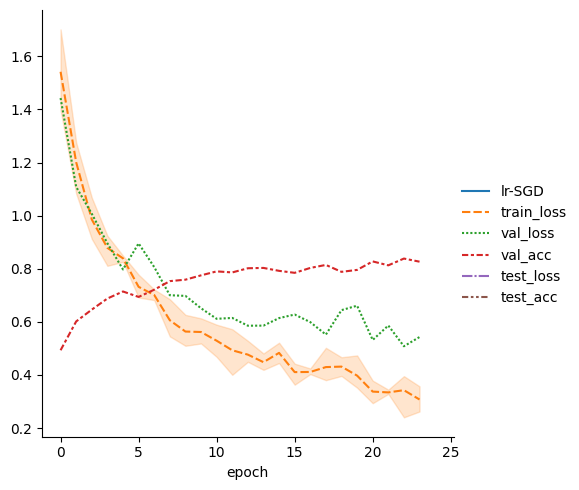

In [23]:
#|export
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")